In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
from tqdm import tqdm
import pickle
import torch
import cv2
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
G, color_edge = skeleton()
import src.procrustes as procrustes
import src.utils as utils

In [2]:
home_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0/'

experiments = ['vid_p6-0_off0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off3_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5']
leg_joints = ['RFbodyCoxa', 'RFfemurTibia', 'RFtibiaTarsus', 'RFclaw',
          'RMbodyCoxa', 'RMfemurTibia', 'RMtibiaTarsus', 'RMclaw',
          'RHbodyCoxa', 'RHfemurTibia', 'RHtibiaTarsus', 'RHclaw',
          'LFbodyCoxa', 'LFfemurTibia', 'LFtibiaTarsus', 'LFclaw', 
          'LMbodyCoxa', 'LMfemurTibia', 'LMtibiaTarsus', 'LMclaw',
          'LHbodyCoxa', 'LHfemurTibia', 'LHtibiaTarsus', 'LHclaw']
central_joints = ['RFbodyCoxa', 'RMbodyCoxa', 'RHbodyCoxa', 'LFbodyCoxa', 'LMbodyCoxa', 'LHbodyCoxa', 'Reye', 'Leye', 'Thorax', 'Abdomen']
ids = [1, 2, 3, 4,  6, 7, 8, 9,  11, 12, 13, 14,  16, 17, 18, 19,  21, 22, 23, 24,  26, 27, 28, 29]

prism_data = '/data/LiftFly3D/prism/data_oriented/training_data/191125_PR_Fly1_001_prism.pkl'

Preprocess data

In [3]:
data_all = []
X=None
for i in tqdm(range(len(experiments))):
    data = pd.read_hdf(home_dir + experiments[i]) #load data
    data = data.droplevel('scorer',axis=1) #drop scorer column label

    #rotate flies pointing left
    theta = np.radians(90)
    cos, sin = np.cos(theta), np.sin(theta)
    R = np.array(((cos, -sin), (sin, cos)))
    
    xy = data.loc[:,(slice(None),['x','y'])].to_numpy().copy() 
    n = xy.shape[1]
    xy = xy.reshape(-1,2)
    xy = np.matmul(xy - 68,R) + 68
    xy = xy.reshape(-1,n)
    
    data.loc[:,(slice(None),['x','y'])] = xy
    
    xy = data.loc[:,(central_joints,['x','y'])].to_numpy()
    
    #procrustes on coxa_femurs to decrease shaking
    #for i in range(xy.shape[0]):
    #    if X is None:
    #        X = xy[41,:].reshape(-1, 2)
    #    Xtransf = xy[i,:].reshape(-1, 2)
                                
        #_, Xtransf, _ = procrustes(X, Xtransf)
    #    _, _, T, _, c = procrustes.compute_similarity_transform(Xtransf, X)
        #Xtransf = (T@Xtransf.T).T + c
    #    Xtransf = Xtransf + c

    #    xy[i,:] = Xtransf.reshape(-1, 2*len(central_joints)).flatten()
        
    data.loc[:,(central_joints,['x','y'])] = xy
    
    #select only leg joints
    data_np = data.loc[:,(leg_joints,['x','y'])].to_numpy()
    
    #save in DF3D format
    xy = np.stack((data_np[:,::2], data_np[:,1::2]), axis=2)
    data_all.append(xy)
    
data_all = np.vstack(data_all)    
poses = {'points2d': data_all}
    
#save
#pickle.dump(poses,open(home_dir + experiments[i][:-3] + '.pkl', 'wb'))
pickle.dump(poses,open(home_dir + 'optobot_2d_pose_Fly0.pkl', 'wb'))

100%|██████████| 7/7 [00:00<00:00, 22.56it/s]


In [4]:
data_all.shape

(2399, 24, 2)

Overlay DLC predictions with video

In [5]:
experiments[1]

'vid_p6-0_on0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5'

(-0.5, 137.5, 137.5, -0.5)

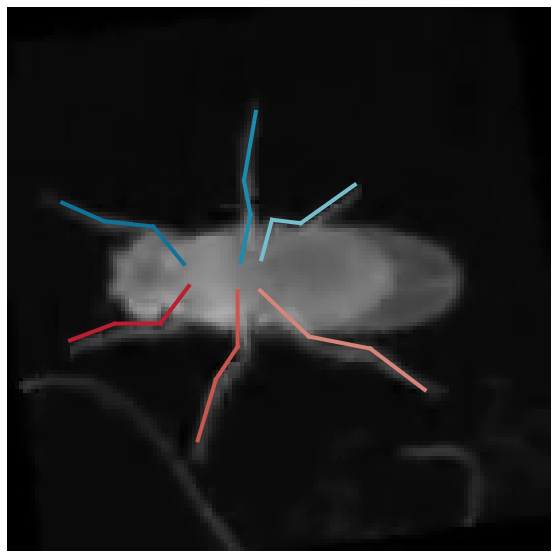

In [6]:
def plot_skeleton(x, y, ids, color_edge, ax=None):
           
    for i, j in enumerate(G.edges()): 
        if (j[0] in ids) & (j[1] in ids):
            u = np.where(j[0]==np.array(ids))[0][0]
            v = np.where(j[1]==np.array(ids))[0][0]
            
            x_coord = np.array((x[u], x[v]))
            y_coord = np.array((y[u], y[v]))
            if ax is not None:
                ax.plot(x_coord, y_coord, c=color_edge[j[0]], linewidth = 4)
            else:
                plt.plot(x_coord, y_coord, c=color_edge[j[0]], linewidth = 4)

imgs = utils.video_to_imgs(home_dir + '_'.join(experiments[1].split('_')[:4] + ['.mp4']))
data = pickle.load(open(home_dir + experiments[1][:-3] + '.pkl','rb'))
#data = pickle.load(open(home_dir + 'optobot_2d_pose_Fly0.pkl','rb'))
poses = data['points2d']

i = 40

plt.figure(figsize=(10,10))
im_rot = ndimage.rotate(imgs[i],90)
plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
plot_skeleton(poses[i,:,0], poses[i,:,1], ids, color_edge)
plt.axis('off')

DLC video

100%|██████████| 38/38 [00:01<00:00, 23.78it/s]


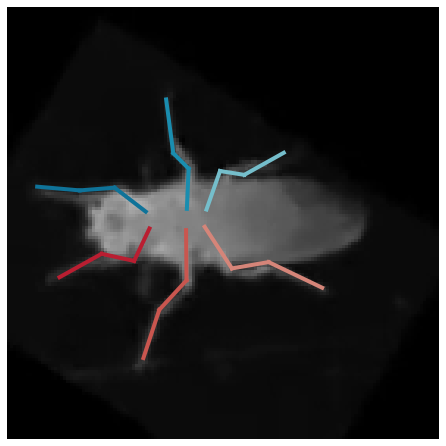

In [7]:
#full image
fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
            
metadata = dict(title='LiftFly3D prediction', artist='Nely',comment='Watch this!')
writer = FFMpegWriter(fps=10, metadata=metadata)
with writer.saving(fig, "DLC_prediction.mp4", 100):
    for exp in range(len(experiments)):
        imgs = utils.video_to_imgs(home_dir + '_'.join(experiments[exp].split('_')[:4] + ['.mp4']))
        data = pickle.load(open(home_dir + experiments[exp][:-3] + '.pkl','rb'))
        poses = data['points2d']
        
        for i in tqdm(range(poses.shape[0])):
            pos_pred, pos_tar = [], []   
            plt.cla()
        
            im_rot = ndimage.rotate(imgs[i],90)
            plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
                 
            plot_skeleton(poses[i,:,0],poses[i,:,1], ids, color_edge)
        
            plt.axis('off')
            writer.grab_frame() 

Arena video

In [8]:
imgs = utils.video_to_imgs('arena.mp4')

Add circle around fly 0

In [10]:
import cv2

#for i in range()
#image = cv2.imread(path) 

count = 0
r = 70
thickness = 5
for i in range(len(experiments)):
    pos = np.load(home_dir + '_'.join(experiments[i].split('_')[:4] + ['.npy']))
    for j in range(pos.shape[0]):

        imgs[count] = cv2.circle(imgs[count], (int(pos[j,0]), int(pos[j,1])), r, (255, 255, 255), thickness) 
        count += 1
        #plt.imshow(image)
        #import sys
        #sys.exit()
        
out = cv2.VideoWriter('arena_marked.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, (imgs[0].shape[0], imgs[0].shape[1]))
 
for i in range(len(imgs)):
    out.write(imgs[i])
out.release()

In [ ]:
#Stack videos horizontally
#ffmpeg -i DLC_prediction.mp4 -i prediction_cams.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output.mp4
#ffmpeg -i arena_marked.mp4 -i output.mp4 -filter_complex "[0:v]scale=-1:480[v0];[v0][1:v]hstack=inputs=2" output_2.mp4



Check data after preprocessing

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


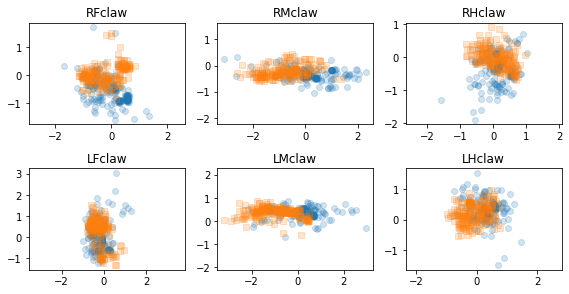

In [13]:
def unNormalizeData(data, data_mean, data_std):
    """
    Un-normalizes a matrix whose mean has been substracted and that has been divided by
    standard deviation. Some dimensions might also be missing
    """
    data *= data_std
    data += data_mean
    
    return data

tint = [200,200]
times = np.arange(tint[0],tint[1])

prism_dir = '/data/LiftFly3D/optobot/network/'
optobot_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0/'

poses_optobot = torch.load(optobot_dir + 'test_2d.pth.tar')
poses_prism = torch.load(prism_dir + 'train_2d.pth.tar')

poses_optobot = np.vstack(poses_optobot.values())
poses_prism = np.vstack(poses_prism.values())

targets_1d = torch.load(optobot_dir + '/stat_2d.pth.tar')['targets_1d'] 
#targets_2d = torch.load(prism_dir + '/stat_2d.pth.tar')['targets_2d']   
#mean = torch.load(optobot_dir + '/stat_2d.pth.tar')['mean']
#std = torch.load(optobot_dir + '/stat_2d.pth.tar')['std']
#poses_optobot = unNormalizeData(poses_optobot, mean[targets_2d], std[targets_2d])
#poses_prism = unNormalizeData(poses_prism, mean[targets_2d], std[targets_2d])

poses_optobot = np.stack((poses_optobot[:,::2], poses_optobot[:,1::2]), axis=2)
poses_prism = np.stack((poses_prism[:,::2], poses_prism[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

joint_id = [2, 5, 8, 11, 14, 17] #legtips
#joint_id = [1, 2, 4,5, 7,8, 10,11, 13,14, 16,17]
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(leg_joints[targets_1d[k]])
    
    #for i in [2, 5, 8, 11, 14, 17]:#[4,9,14,19,24,29]:
    plt.plot(poses_prism[times,k,0], poses_prism[times,k,1],'o',alpha=0.2)
    
    #for i in :#[3,7,11,15,19,23]:
    
    plt.plot(poses_optobot[times,k,0], poses_optobot[times,k,1],'s',alpha=0.2)
    plt.axis('equal')
    
plt.tight_layout()
#plt.savefig('pose_distributions.png')